# Pitch & Roll sequence prediction

In [1]:
import gc
import os
import json
import math
import pickle
import random

import platform
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [2]:
print(torch.__version__)
print(pl.__version__)

1.11.0
1.6.1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 16
Platform: windows
number of workers: 0


# Train results

In [ ]:
c = 0
models = []
files = []
results = {}
dir = "training_results"
colors = [name for name, _ in pltcolors.cnames.items()]
random.shuffle(colors)
colors.extend(list("rgbcmyk"))

In [9]:
"""plt.figure(figsize=(14, 9))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for model in os.listdir(dir):
    results[model] = []
    for file in os.listdir(dir+"/"+model):
        results[model].append(file)

# sort files in reverse alphabetical order to group them by model parameters
# [train 1, train 2, val 1, val 2] becomes [train 1, val 1, train 2, val 2]     
for model, filenames in results.items():
    results[model] = sorted(filenames, key=lambda x: x[::-1])
    for file in results[model]:
        _, _, in_f, out_f, _ = file.split("_")
        with open(f'{dir}/{model}/{file}', "rb") as f:
            array = pickle.load(f)
            if(file[0] == "t"):
                label = f"{model}_train_{in_f}_{out_f}"
                plt.plot(array, label=label, color=colors[c])
                c += 1
            else:
                label = f"{model}_val_{in_f}_{out_f}"
                plt.plot(array, label=label, color=colors[c], linestyle='dashed')

plt.ylabel("Average MSE loss")
plt.xlabel("Number of epochs")
plt.title("MSE losses during training for all models")
plt.legend()
plt.savefig('../results/training_results/all')
plt.show()"""

'plt.figure(figsize=(14, 9))\n\n# build dictionary with same structure as training results folders:\n# modelname -> [train loss 1, val loss1, train loss 2, ...]\nfor model in os.listdir(dir):\n    results[model] = []\n    for file in os.listdir(dir+"/"+model):\n        results[model].append(file)\n\n# sort files in reverse alphabetical order to group them by model parameters\n# [train 1, train 2, val 1, val 2] becomes [train 1, val 1, train 2, val 2]     \nfor model, filenames in results.items():\n    results[model] = sorted(filenames, key=lambda x: x[::-1])\n    for file in results[model]:\n        _, _, in_f, out_f, _ = file.split("_")\n        with open(f\'{dir}/{model}/{file}\', "rb") as f:\n            array = pickle.load(f)\n            if(file[0] == "t"):\n                label = f"{model}_train_{in_f}_{out_f}"\n                plt.plot(array, label=label, color=colors[c])\n                c += 1\n            else:\n                label = f"{model}_val_{in_f}_{out_f}"\n        

### Single-step model

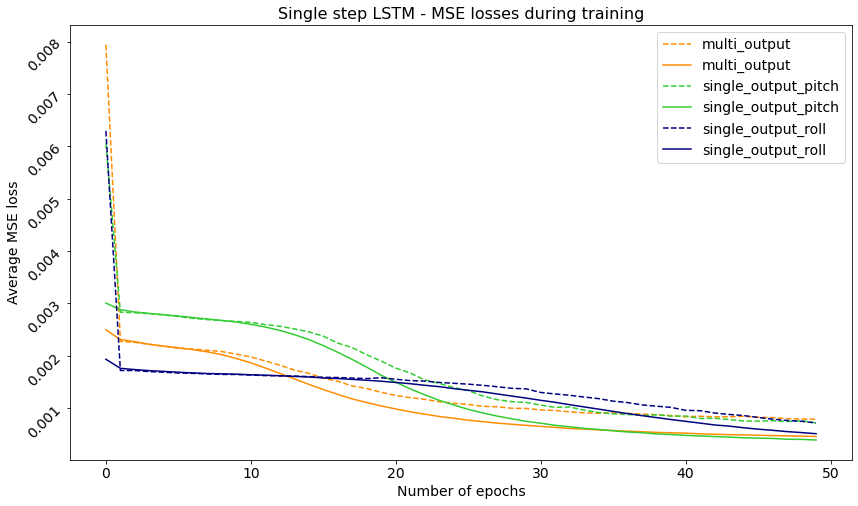

In [131]:
c = 0
font  = 14
models = []
files = []
results = {}
dir = "training_results"
colors = ["darkorange", "limegreen", "navy"]
singlestep = ["LSTM_PR_multi_output", "LSTM_PR_single_output_roll", "LSTM_PR_single_output_pitch"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 8))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for model in os.listdir(dir):
    results[model] = []
    for file in os.listdir(dir+"/"+model):
        results[model].append(file)

# sort files in reverse alphabetical order to group them by model parameters
# [train 1, train 2, val 1, val 2] becomes [train 1, val 1, train 2, val 2]     
for model, filenames in results.items():
    if(model in singlestep):
        results[model] = sorted(filenames, key=lambda x: x[::-1])
        for file in results[model]:
            _, _, in_f, out_f, _ = file.split("_")
            if(out_f == "1out" and in_f == "10in"):
                with open(f'{dir}/{model}/{file}', "rb") as f:
                    array = pickle.load(f)
                    modelname = model.split("_")[2:]
                    modelname = "_".join(modelname)
                    if(file[0] == "t"):
                        label = f"{modelname}"
                        plt.plot(array, label=label, color=colors[c])
                        c += 1
                    else:
                        label = f"{modelname}"
                        plt.plot(array, label=label, color=colors[c], linestyle='dashed')

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
plt.title("Single step LSTM - MSE losses during training", fontsize = font+2)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
plt.legend(handles, labels, ncol=1, fontsize=font)
plt.savefig('../results/training_results/single-step', bbox_inches='tight')
plt.show()

### Encoder-Decoder LSTM

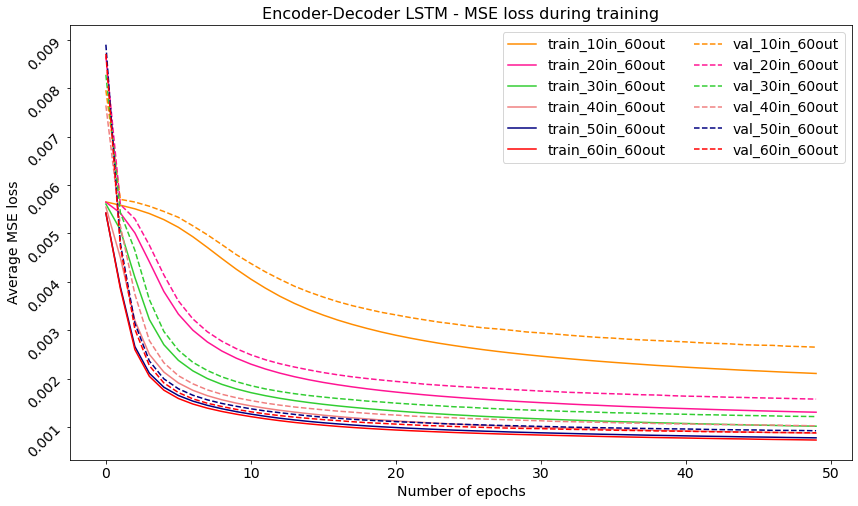

In [121]:
c = 0
font = 14
models = []
files = []
results = {}
dir = "training_results"
colors = ["darkorange", "deeppink", "limegreen", "lightcoral", "navy"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 8))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for model in os.listdir(dir):
    results[model] = []
    for file in os.listdir(dir+"/"+model):
        results[model].append(file)

# sort files in reverse alphabetical order to group them by model parameters
# [train 1, train 2, val 1, val 2] becomes [train 1, val 1, train 2, val 2]     
for model, filenames in results.items():
    if(len(model.split("_")) < 3 or model.split("_")[2] != "sequence"):
        continue
    results[model] = sorted(filenames, key=lambda x: x[::-1])
    for file in results[model]:
        _, _, in_f, out_f, _ = file.split("_")
        if(not out_f == "120out"):
            with open(f'{dir}/{model}/{file}', "rb") as f:
                array = pickle.load(f)
                if(file[0] == "t"):
                    label = f"train_{in_f}_{out_f}"
                    plt.plot(array, label=label, color=colors[c])
                    c += 1
                else:
                    label = f"val_{in_f}_{out_f}"
                    plt.plot(array, label=label, color=colors[c], linestyle='dashed')

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
plt.legend(handles, labels, ncol=2, fontsize=font)
plt.title("Encoder-Decoder LSTM - MSE loss during training", fontsize=font+2)
plt.savefig('../results/training_results/lstm-sequence', bbox_inches='tight')
plt.show()

### CNN LSTM single input

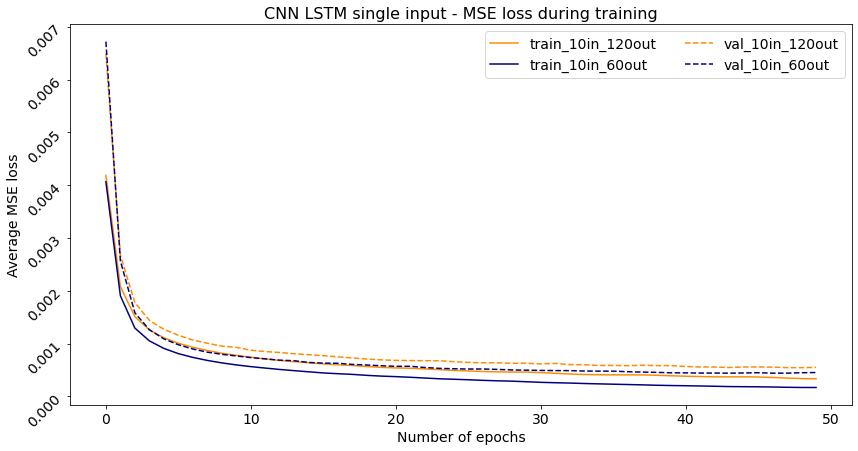

In [112]:
c = 0
font = 14
models = []
files = []
results = {}
dir = "training_results"
colors = ["darkorange", "navy", "limegreen", "deeppink",  "grey"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 7))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for model in os.listdir(dir):
    results[model] = []
    for file in os.listdir(dir+"/"+model):
        results[model].append(file)

# sort files in reverse alphabetical order to group them by model parameters
# [train 1, train 2, val 1, val 2] becomes [train 1, val 1, train 2, val 2]     
for model, filenames in results.items():
    if(model.split("_")[1] != "img-to-PR"):
        continue
    results[model] = sorted(filenames, key=lambda x: x[::-1])
    for file in results[model]:
        type, _, in_f, out_f, _ = file.split("_")
        with open(f'{dir}/{model}/{file}', "rb") as f:
            array = pickle.load(f)
            if(file[0] == "t"):
                label = f"{type}_{in_f}_{out_f}"
                plt.plot(array, label=label, color=colors[c])
                c += 1
            else:
                label = f"{type}_{in_f}_{out_f}"
                plt.plot(array, label=label, color=colors[c], linestyle='dashed')

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
plt.title("CNN LSTM single input - MSE loss during training", fontsize=font+2)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
plt.legend(handles, labels, ncol=2, fontsize=font)
plt.savefig('../results/training_results/cnn', bbox_inches='tight')
plt.show()

### Parameter testing

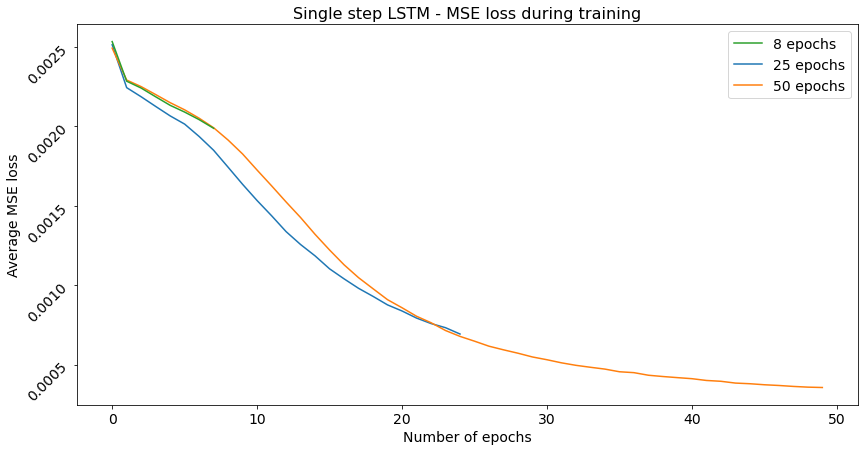

In [111]:
c = 0
font = 14
models = []
files = []
results = {}
dir = "training_results/test_LSTM_PR_multi_output"
colors = ["darkorange", "limegreen", "navy"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 7))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for file in os.listdir(dir):
    type, _, inf, outf, epochs, lr, hid = file.split("_")
    if(type == "train" and lr == f"{0.001}lr" and hid == f"{128}hidden"):
        with open(f'{dir}/{file}', 'rb') as f:
            array = pickle.load(f)
            plt.plot(array, label = f"{epochs[:-6]} epochs")

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
plt.title("Single step LSTM - MSE loss during training", fontsize=font+2)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0][0:2])))
plt.legend(handles, labels, fontsize=font)
plt.savefig('../results/training_results/epoch_tests', bbox_inches='tight')
plt.show()

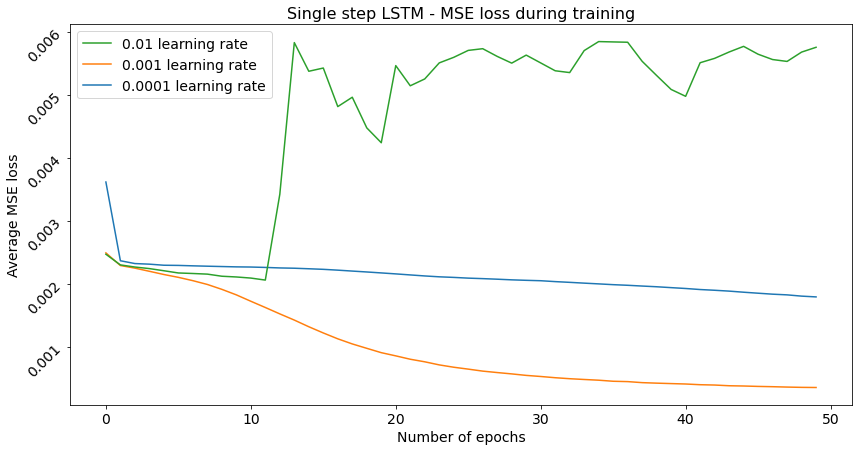

In [110]:
c = 0
font = 14
models = []
files = []
results = {}
dir = "training_results/test_LSTM_PR_multi_output"
colors = ["darkorange", "limegreen", "navy"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 7))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for file in os.listdir(dir):
    type, _, inf, outf, epochs, lr, hid = file.split("_")
    if(type == "train" and epochs == f"{50}epochs" and hid == f"{128}hidden"):
        with open(f'{dir}/{file}', 'rb') as f:
            array = pickle.load(f)
            plt.plot(array, label = f"{lr[:-2]} learning rate")

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
plt.title("Single step LSTM - MSE loss during training", fontsize=font+2)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
plt.legend(handles, labels, fontsize=font)
plt.savefig('../results/training_results/lr_tests', bbox_inches='tight')
plt.show()

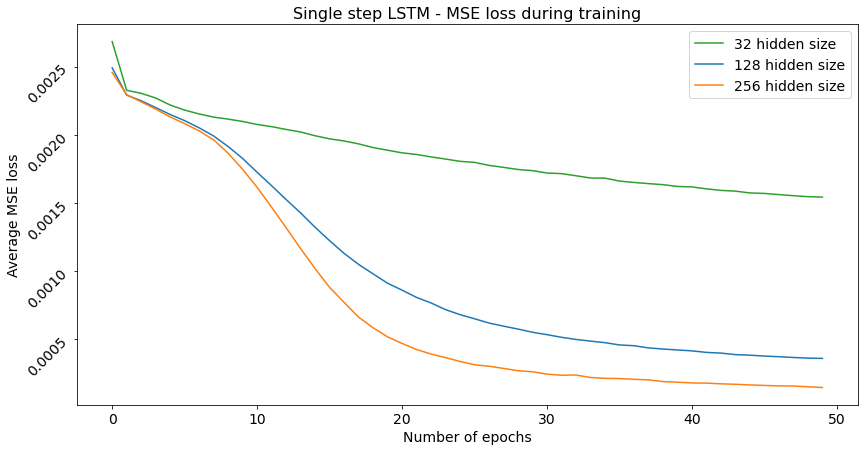

In [109]:
c = 0
font = 14
models = []
files = []
results = {}
dir = "training_results/test_LSTM_PR_multi_output"
colors = ["darkorange", "limegreen", "navy"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 7))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for file in os.listdir(dir):
    type, _, inf, outf, epochs, lr, hid = file.split("_")
    if(type == "train" and epochs == f"{50}epochs" and lr == f"{0.001}lr"):
        with open(f'{dir}/{file}', 'rb') as f:
            array = pickle.load(f)
            plt.plot(array, label = f"{hid[:-6]} hidden size")

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
plt.title("Single step LSTM - MSE loss during training", fontsize=font+2)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0][0:3])))
plt.legend(handles, labels, fontsize=font)
plt.savefig('../results/training_results/hidden_tests', bbox_inches='tight')
plt.show()